In [1]:
import sys
sys.path.insert(0, "../")
import time
import numpy as np
from pinn import *
from grad_stats import *

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import grad
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

from tqdm import tqdm_notebook as tqdm 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

seed 1


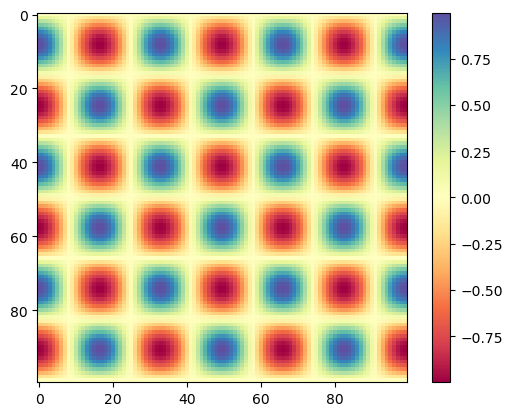

In [3]:
# experiment setup
lx=ly=0
rx=ry=1
seed   = 1
omega = 6*np.pi

print("seed", seed)

# genereate ground truth
def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)

X = np.vstack([xx.ravel(), yy.ravel()]).T
plt.imshow(u_sol, cmap="Spectral")
plt.colorbar()


In [4]:

def sampler(num_r=2500, num_b=100,lx=0,rx=1,ly=0,ry=1,seed=1):
    # generate training data
    x = np.linspace(lx, rx, 100)
    y = np.linspace(ly, ry, 100)
    xb = np.linspace(lx,rx,num_b)
    yb = np.linspace(ly,ry,num_b)
    
    xx,yy = np.meshgrid(x,y)
    
    X = np.vstack([xx.ravel(), yy.ravel()]).T


    # X boundaries
    lb   = lx*np.ones((yb.shape))
    rb   = rx*np.ones((yb.shape))
    Xlb  = np.vstack((lb,yb)).T
    Xrb  = np.vstack((rb,yb)).T
    UXlb = np.cos(omega*Xlb[:,0])*np.sin(omega*Xlb[:,1])
    UXrb = np.cos(omega*Xrb[:,0])*np.sin(omega*Xrb[:,1])

    # Y boundaries
    lb   = ly*np.ones((xb.shape))
    rb   = ry*np.ones((xb.shape))
    Ylb  = np.vstack((xb,lb)).T
    Yrb  = np.vstack((xb,rb)).T
    UYlb = np.cos(omega*Ylb[:,0])*np.sin(omega*Ylb[:,1])
    UYrb = np.cos(omega*Yrb[:,0])*np.sin(omega*Yrb[:,1])

    seedc = seed
    np.random.seed(seedc)
    torch.manual_seed(seedc)

    # training tensors
    idxs = np.random.choice(xx.size, num_r, replace=False)
    X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True,device=device)
    X_rb = torch.tensor(Xrb, dtype=torch.float32, device=device)
    X_lb = torch.tensor(Xlb, dtype=torch.float32, device=device)
    Y_rb = torch.tensor(Yrb, dtype=torch.float32, device=device)
    Y_lb = torch.tensor(Ylb, dtype=torch.float32, device=device)
    # compute mean and std of training data
    X_mean = torch.tensor(np.mean(np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0), axis=0, keepdims=True), dtype=torch.float32, device=device)
    X_std  = torch.tensor(np.std(np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0), axis=0, keepdims=True), dtype=torch.float32, device=device)
    
    U_X_rb = torch.tensor(UXrb, dtype=torch.float32, device=device).reshape(num_b,1)
    U_X_lb = torch.tensor(UXlb, dtype=torch.float32, device=device).reshape(num_b,1)
    U_Y_rb = torch.tensor(UYrb, dtype=torch.float32, device=device).reshape(num_b,1)
    U_Y_lb = torch.tensor(UYlb, dtype=torch.float32, device=device).reshape(num_b,1)
    

    return X_train, X_lb, X_rb, Y_lb, Y_rb, U_X_lb, U_X_rb, U_Y_lb, U_Y_rb, X_mean, X_std

In [5]:
# computes pde residual
def poisson_res(uhat, data, omega):
    xin = data[:,0:1]
    yin = data[:,1:2]
    du = grad(outputs=uhat, inputs=data, grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    dudx = du[:,0:1]
    dudxx = grad(outputs=dudx, inputs=data,grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudy = du[:,1:2]
    dudyy = grad(outputs=dudy, inputs=data,grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,1:2]
    source = -2.0*omega*omega*torch.cos(omega*xin)*torch.sin(omega*yin) + 0*uhat
    residual = dudxx + dudyy - source
    return residual

In [6]:
def plot_function(lx,rx,ly,ry,u_sol,out,method):
    methods=["W1 (uniform)","W2 (max_by_mean)","W3 (std)","W4 (mean+std)","W5 (mean*std)","W6 (kurtosis)"]
    plt.subplot(1,3,1)
    plt.imshow(u_sol, cmap="twilight", origin="lower",vmin=-1.0,vmax=1.0)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Ground Truth",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1,3,2)
    plt.imshow(out, cmap="twilight", origin="lower",vmin=-1.0,vmax=1.0)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Prediction",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1,3,3)
    plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="nipy_spectral", origin="lower",vmin=0,vmax=0.2)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Point-wise Error",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.gcf().set_size_inches(15,5)
    plt.tight_layout()
    plt.suptitle("Poisson Equation using PINN_{}".format(methods[method]),fontsize=25)
    plt.savefig("PoissonEqn_{}_based".format(methods[method]),dpi=800)
    return None

In [6]:
losses_boundary_global=[]
losses_residual_global=[]
all_losses=[]
lambdas_global=[]
list_of_l2_Errors=[]
for i in range(6):
    for j in range(5):
        mm         = 5
        alpha_ann  = 0.5
        n_epochs   = 40_001
        method = i
        X_train, X_lb, X_rb, Y_lb, Y_rb, U_X_lb, U_X_rb, U_Y_lb, U_Y_rb, X_mean, X_std= sampler(seed=j)
        net = PINN(sizes=[2,50,50,50,50,50,50,50,1], mean=X_mean, std=X_std, seed=j, activation=torch.nn.SiLU()).to(device)
        lambd       = 1
        lambds      = [];
        losses_boundary  = [];
        losses_residual = [];
        params = [{'params': net.parameters(), 'lr': 1e-3}]
        milestones = [[10000,20000,30000]]
        optimizer = Adam(params)
        scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
        print("training with shape", X_train.size())
        start_time = time.time()
        for epoch in range(n_epochs):     
            uhat  = net(X_train)
            res   = poisson_res(uhat, X_train, omega)
            l_reg = torch.mean((res)**2)
            predl = net(X_lb)
            predr = net(X_rb)
            l_bc  = torch.mean((predl - U_X_lb)**2, dim=0)
            l_bc += torch.mean((predr - U_X_rb)**2, dim=0)
            predl = net(Y_lb)
            predr = net(Y_rb)
            l_bc += torch.mean((predl - U_Y_lb)**2, dim=0)
            l_bc += torch.mean((predr - U_Y_rb)**2, dim=0)    
            with torch.no_grad():
                if epoch % mm == 0:
                    stdr,kurtr=loss_grad_stats(l_reg, net)
                    stdb,kurtb=loss_grad_stats(l_bc, net)
                    maxr,meanr=loss_grad_max_mean(l_reg, net)
                    maxb,meanb=loss_grad_max_mean(l_bc, net,lambg=lambd)
                    if method == 2:
                        # inverse dirichlet
                        lamb_hat = stdr/stdb
                        lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat
                    elif method == 1:
                        # max/avg
                        lamb_hat = maxr/meanb
                        lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat 
                    elif method==3:
                        # mean + std weighing
                        covr= stdr + maxr
                        covb= stdb + meanb
                        lamb_hat = covr/covb
                        lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat   
                    elif method == 5:
                        # kurtosis based weighing
                        covr= stdr/kurtr
                        covb= stdb/kurtb
                        lamb_hat = covr/covb
                        lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat
                    elif method == 4:
                        # mean * std weighing
                        covr= stdr * meanr
                        covb= stdb * meanb
                        lamb_hat = covr/covb
                        lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat
                    else:
                        # uniform weighing 
                        lambd = 1;
            if(method == 0):
                loss = l_reg + l_bc
            elif(method == 1 or method == 2 or method==3 or method==4 or method == 5):
                loss = l_reg + lambd*l_bc
            if epoch%250==0:
                all_losses.append(loss.item())
                inp = torch.tensor(X, dtype=torch.float32, device=device)
                out = net(inp).cpu().data.numpy().reshape(u_sol.shape)
                list_of_l2_Errors.append(np.linalg.norm(out.reshape(-1)-u_sol.reshape(-1))/np.linalg.norm(out.reshape(-1)))

                #losses_boundary.append(l_bc.item())
                #losses_residual.append(l_reg.item())
                if method !=0:
                    lambds.append(lambd.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
                  .format(epoch+1, n_epochs, loss.item(), lambd, optimizer.param_groups[0]['lr']), end="\r")
        elapsed_time = time.time() - start_time
        #print('CPU time = ',elapsed_time)
        inp = torch.tensor(X, dtype=torch.float32, device=device)
        out = net(inp).cpu().data.numpy().reshape(u_sol.shape)
        print("\n.....\n")
        print("Method:",method)
        print("pred rel. l2-error = {:e}".format(np.linalg.norm(out.reshape(-1)-u_sol.reshape(-1))/np.linalg.norm(out.reshape(-1))))
        print("\n.....\n")
        #plot_function(lx,rx,ly,ry,u_sol,out,method)
        
        #losses_boundary_global.append(losses_boundary)
        #losses_residual_global.append(losses_residual)

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.3088310659, lambda=1.0000, lr=0.00000						
.....

Method: 0
pred rel. l2-error = 9.084669e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.5178486109, lambda=1.0000, lr=0.00000						
.....

Method: 0
pred rel. l2-error = 1.007622e-01

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.3442910910, lambda=1.0000, lr=0.00000						
.....

Method: 0
pred rel. l2-error = 1.026083e-01

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.2443611622, lambda=1.0000, lr=0.00000						
.....

Method: 0
pred rel. l2-error = 8.675805e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=1.4366407394, lambda=1.0000, lr=0.00000						
.....

Method: 0
pred rel. l2-error = 1.520970e-01

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.3898228109, lambda=49.4004, lr=0.00000								
.....

Method: 1
pred rel. l2-

2898

In [7]:
def split(list_a, chunk_size):

  for i in range(0, len(list_a), chunk_size):
    yield list_a[i:i + chunk_size]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


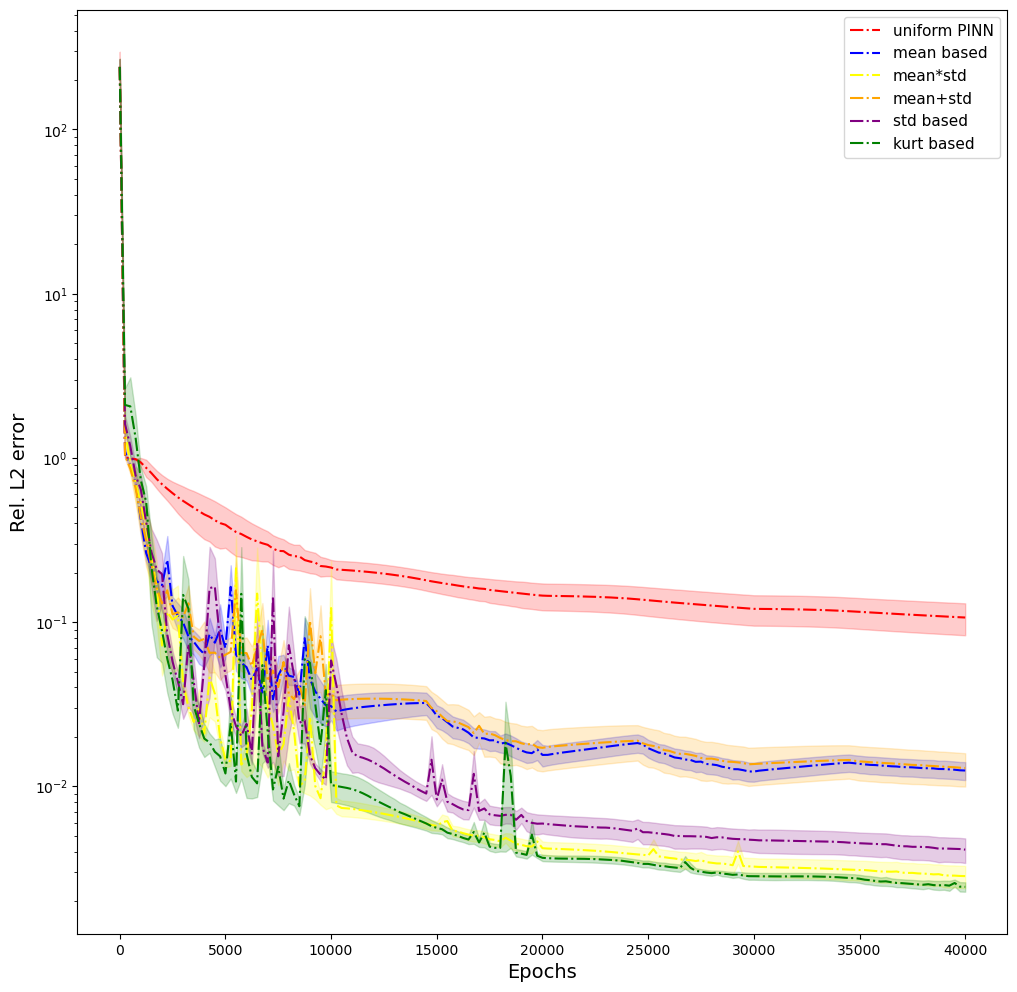

In [8]:
List = list(split(list_of_l2_Errors,161))
errs=[]
stds= []

All_list = list(split(List,5))
for i in All_list:
    errs.append(np.mean(i,axis=0))
    stds.append(np.std(i,axis=0))
fig,ax = plt.subplots(1,1,figsize=(10,14))
colors = ["red", "blue","yellow" ,"orange", "purple", "green"]
labels = ["uniform PINN", "mean based","mean*std" ,"mean+std" ,"std based","kurt based"]
markers = ["o", "d", "s", "p", "v","x"]
linestyle= ["dotted", "dashed","dashdot", "" ]
for i in range(6):

    ax.plot(range(0,40001,250), errs[i], colors[i], label=labels[i],linestyle="dashdot")
    if i ==0 :
        ax.fill_between(range(0,40001,250), errs[i]-(stds[i]), errs[i]+(stds[i]), color=colors[i], alpha=0.2)
    else:
        ax.fill_between(range(0,40001,250), errs[i]-(.5*stds[i]), errs[i]+(.5*stds[i]), color=colors[i], alpha=0.2)
    
ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Rel. L2 error", fontsize=14)
ax.legend(fontsize=11)
ax.set_yscale("log")
#ax.set_xscale("log")

plt.gcf().set_size_inches(12,12)
plt.savefig("poisson_erros_rms_1e5.eps")

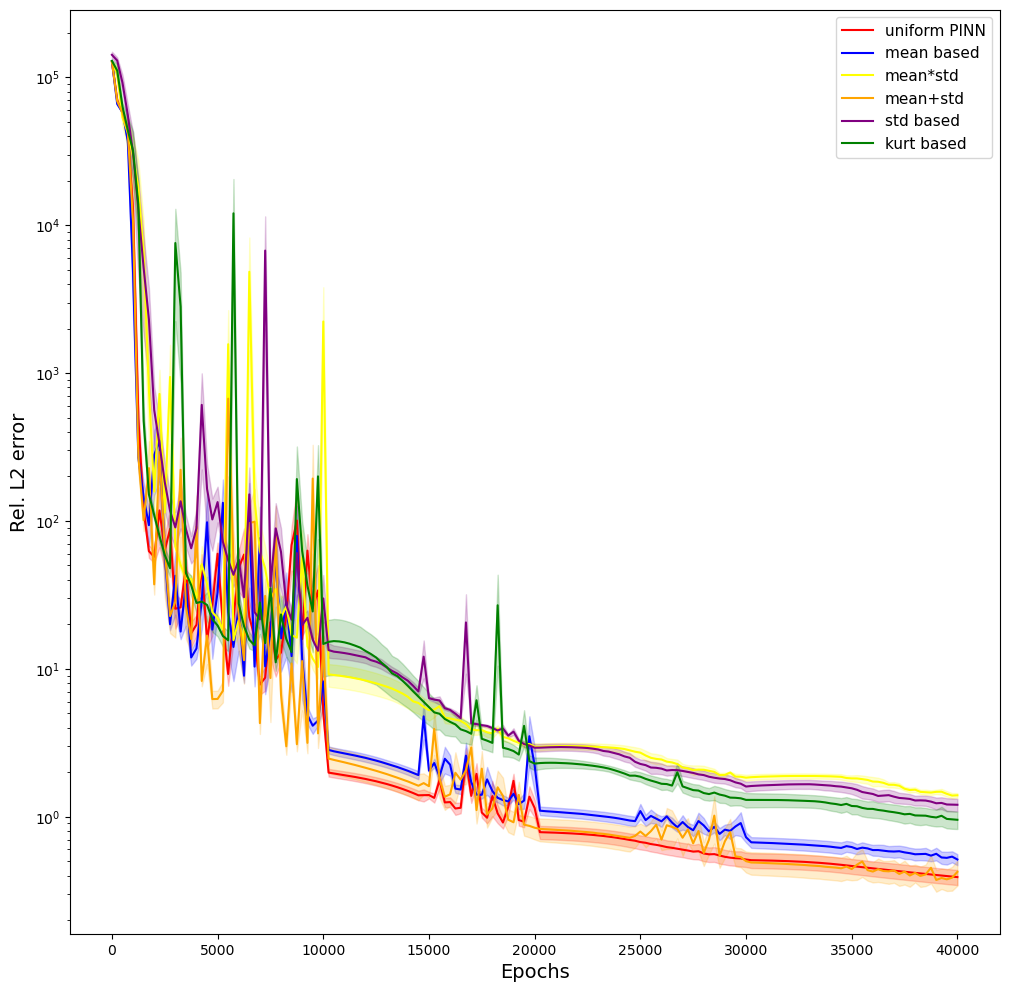

In [74]:
List = list(split(all_losses,161))
errs=[]
stds= []

All_list = list(split(List,3))
for i in All_list:
    errs.append(np.mean(i,axis=0))
    stds.append(np.std(i,axis=0))
fig,ax = plt.subplots(1,1,figsize=(10,14))
colors = ["red", "blue","yellow" ,"orange", "purple", "green"]
labels = ["uniform PINN", "mean based","mean*std" ,"mean+std" ,"std based","kurt based"]
markers = ["o", "d", "s", "p", "v","x"]
for i in range(6):

    ax.plot(range(0,40001,250), errs[i], colors[i], label=labels[i])
    
    ax.fill_between(range(0,40001,250), errs[i]-(.5*stds[i]), errs[i]+(.5*stds[i]), color=colors[i], alpha=0.2)
    
ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Rel. L2 error", fontsize=14)
ax.legend(fontsize=11)
ax.set_yscale("log")
#ax.set_xscale("log")

plt.gcf().set_size_inches(12,12)
#plt.savefig("poisson_erros_rms_1e5.eps")